In [1]:
import fastai
from fastai import learner
from fastai import dataset
from fastai import model
from fastai.model import resnet34
from pathlib import Path
from fastai.text import *

import pandas as pd
import numpy as np
import spacy
import json
import re
import html

torch.cuda.device(0)

In [38]:
spac_tok = spacy.load("en")

In [2]:
torch.cuda.current_device()

0

In [4]:
PATH = Path("data/nlidb-datasets/")

In [5]:
sql_train = json.load((PATH/"SENLIDB"/"train.json").open())
sql_test = json.load((PATH/"SENLIDB"/"test.json").open())

In [6]:
sql_test[0]

{'annotations': [{'annotation': 'List the top 50000 posts that have been viewed more than 10000 times ordered by the number of views descending',
   'annotator_id': 1},
  {'annotation': 'Get the most viewed 50000 posts that have the number of views higher than 10000, ordered by the count of views',
   'annotator_id': 1},
  {'annotation': 'show top 50000 posts which have more than 10000 views',
   'annotator_id': 2},
  {'annotation': 'select top 50000 posts that have over 10000 ordered descending',
   'annotator_id': 2}],
 'comments': [],
 'description': '',
 'id': '641175',
 'sql': 'select top 50000 * from posts where posts.ViewCount > 10000 ORDER BY posts.ViewCount desc',
 'sql_plain': 'select top 50000 * from posts where posts.ViewCount > 10000 ORDER BY posts.ViewCount desc',
 'title': '10000',
 'url': 'http://data.stackexchange.com/stackoverflow/revision/641175/800950/10000'}

In [7]:
def DataFrameCreate(jsondata):
    sql_plain = []
    title = []
    for i,o in enumerate(jsondata):
        sql_plain.append(o["sql_plain"])
        title.append(o["title"])
    df = pd.DataFrame({"title":title, "sql_plain":sql_plain}, columns={"title", "sql_plain"})
    return df

In [9]:
df_trn = DataFrameCreate(sql_train)
df_test= DataFrameCreate(sql_test)

In [10]:
df_trn

,title,sql_plain
0,Repent 151-160,"SELECT \np.Title,p.score,p.ViewCount,p.AnswerC..."
1,This is test data for my question to make thin...,-- This is test data for my question to make t...
2,Accept answer,select Id\nfrom Comments \nwhere lower(Text) l...
3,Questions with most views created within 3 mon...,"DECLARE @From DATETIME = convert(DATETIME, '##..."
4,Most Prolific Answers,-- Most Prolific Answerers (with score)\n-- Sh...
5,Questions with the default image text,"SELECT Id AS [Post Link], Tags, Score FROM Pos..."
6,Questions with most delete votes,"select top 100 p.Id as [Post Link], max(p.Scor..."
7,Fastest answers,SELECT TOP 100\n q.OwnerUserId AS [User Link]...
8,Bounty distibution,with bounty_questions as (\n select max(1.0*a...
9,Is there a SEDE query to find number of up vot...,select count(*)\nfrom votes v \ninner join pos...


In [11]:
df_trn.to_csv(str(PATH)+"train.csv", index=False, header=False)
df_test.to_csv(str(PATH)+"test.csv", index=False, header=False)

In [8]:
df_trn = pd.read_csv(str(PATH)+"train.csv", header=None)
df_test= pd.read_csv(str(PATH)+"test.csv", header=None)

In [9]:
df_trn.shape

(24594, 2)

In [10]:
df_test.shape

(296, 2)

In [11]:
df_lm = pd.concat((df_trn,df_test), axis=0)

In [12]:
re1 = re.compile(r'  +')
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ').replace(',', ", ")
    return re1.sub(' ', html.unescape(x))

def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values#.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [14]:
tok_lm, _ = get_texts(df_lm, 1)

In [15]:
freq = Counter(p for o in tok_lm for p in o)

In [16]:
max_vocab = 60000
min_freq = 2

In [17]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

In [18]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

15120

In [19]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_lm])

In [20]:
trn_lm

array([ list([6, 20, 21, 12, 2, 11, 6, 275, 4, 148, 4, 242, 4, 342, 4, 709, 4, 2, 553, 5, 10, 5889, 4, 6, 976, 4, 60, 4, 6, 139, 10, 5890, 4, 325, 10, 5891, 4, 6, 254, 9, 2, 1178, 4, 94, 4, 210, 5, 10, 5277, 6, 13, 22, 10, 59, 4, 22, 10, 66, 4, 33, 10, 98, 6, 17, 6, 5278, 15, 6, 1420, 15, 6, 210, 8, 6, 9, 11, 5892, 5, 6, 13, 22, 5893, 6, 17, 5894, 6, 38, 16, 5895, 5, 15, 6, 9, 6, 275, 30, 7, 32, 0, 1968, 133, 0, 0, 13, 0, 9, 73, 2, 0, 7, 52, 6, 275, 30, 7, 32, 1340, 123, 1873, 3426, 80, 73, 184, 73, 1910, 123, 773, 211, 63, 7741, 7, 52, 6, 275, 30, 7, 32, 236, 123, 6545, 66, 211, 876, 5896, 0, 7, 52, 6, 275, 30, 7, 32, 236, 123, 669, 211, 293, 2227, 876, 2463, 63, 7741, 7, 52, 6, 275, 30, 7, 32, 0, 11397, 864, 1222, 9, 606, 11398, 5, 13, 3426, 63, 7741, 7, 52, 6, 275, 30, 7, 32, 3426, 246, 11399, 28, 196, 1512, 39, 750, 2167, 460, 53, 8, 15, 293, 0, 7, 52, 6, 275, 30, 7, 32, 11400, 85, 3426, 15, 0, 7, 52, 6, 275, 30, 7, 32, 386, 28, 251, 680, 123, 11401, 7, 52, 6, 275, 30, 7, 32, 1760,

In [174]:
for i in trn_lm[0]:
    print(itos[i], end=" ")


 xbos xfld 1 t_up select 
 p.title , p.score , p.viewcount , p.answercount , p.commentcount , t_up len(p.body ) as ques_size , 
 p.favoritecount , p.id , 
 u.reputation as user_repo , u.creationdate as user_join_date , 
 datediff ( t_up minute , p.creationdate , a.creationdate ) as qatimegap 
 from posts as p , posts as a , users as u 
 where 
 p.id=a.parentid and 
 p.owneruserid=u.id and 
 a.creationdate = 
 ( select min(tau.creationdate ) 
 from posts tau 
 where tau.parentid=p.id 
 group by tau.parentid ) and 
 ( 
 p.title like ' % _unk_ method for _unk_ _unk_ from _unk_ ( " t_up _unk_ ' or 
 p.title like ' % way to format strings with " ? " parameters to full string in java?% ' or 
 p.title like ' % how to parse a string without regular _unk_ ' or 
 p.title like ' % how to replace string only once without regex in java?% ' or 
 p.title like ' % _unk_ removing specific characters ( some punctuation ) from strings in java?% ' or 
 p.title like ' % strings are immutable - that means 

In [21]:
vs=len(itos)
vs,len(trn_lm)

(15120, 24890)

In [22]:
em_sz,nh,nl = 400,1150,3
wd=1e-7
bptt=70
bs=52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [139]:
??optim.Adam

In [142]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)

In [140]:
??LanguageModelLoader

In [144]:
trn_dl.data


     6     45      2  ...       8      0    344
    20     87     11  ...      12     12   3018
    21     27    204  ...       6     73   1602
        ...            ⋱           ...         
     2     29     17  ...      73     54     20
    11     27    117  ...     130   5077     21
     2      3      8  ...      16     63     12
[torch.cuda.LongTensor of size 46912x52 (GPU 0)]

In [148]:
trn_dl.i

0

In [149]:
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl)

In [150]:
trn_dl.i

0

In [146]:
??LanguageModelData

In [190]:
??get_language_model

In [191]:
??LinearDecoder

In [159]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

In [160]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.unfreeze()

In [189]:
??md.get_model

In [188]:
??LanguageModel

In [162]:
trn_dl.i

0

In [163]:
??learner.lr_find()

In [74]:
learner.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 72%|███████▏  | 485/669 [2:18:05<52:23, 17.08s/it, loss=23]  

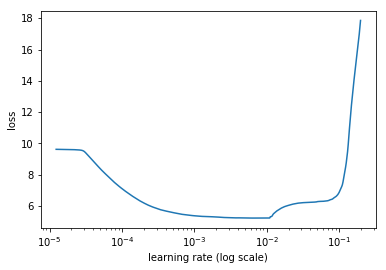

In [77]:
learner.sched.plot()

In [164]:
lr=8e-4
lrs = lr

In [155]:
??learner.fit

In [154]:
??learner.get_layer_opt

In [156]:
??learner.fit_gen

In [165]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      4.652819   4.555349   0.199504  



[4.5553493, 0.19950446813897701]

In [168]:
??trn_dl

In [29]:
learner.save('lm_last_ft')

In [ ]:
learner.load('lm_last_ft')

In [170]:
??learner.freeze_to()

In [171]:
learner.unfreeze()

In [172]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      2.980805   2.79463    0.467613  
    1      2.105871   2.004283   0.588952                   
    2      1.770212   1.668232   0.643377                   
    3      1.591637   1.466413   0.677594                   
    4      1.455723   1.320104   0.703459                   
    5      1.351965   1.210415   0.724306                   
    6      1.258142   1.122119   0.741272                   
    7      1.198309   1.047865   0.756488                   
    8      1.136695   0.989424   0.76831                    
    9      1.098699   0.936767   0.779464                   
    10     1.062754   0.894572   0.788605                   
    11     1.052453   0.860373   0.796523                   
    12     1.010241   0.826484   0.804731                    
    13     0.994387   0.803344   0.810086                    
    14     0.987387   0.788586   0.813596                    



[0.78858626, 0.81359573677516306]

In [32]:
learner.save('lm1')

In [33]:
learner.save_encoder('lm1_enc')

In [40]:
tok = Tokenizer() 

In [41]:
tok.spacy_tok("Don't")

['Do', "n't"]

In [268]:
ss="""xbos xfld 1 select *"""
s = [tok.spacy_tok(ss)]
t = np.array([[stoi[o] for o in p] for p in s])
' '.join(s[0])

'xbos xfld 1 select *'

In [131]:
learner.models.model

SequentialRNN(
  (0): RNN_Encoder(
    (encoder): Embedding(15120, 400, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(15120, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(400, 1150, dropout=0.105)
      )
      (1): WeightDrop(
        (module): LSTM(1150, 1150, dropout=0.105)
      )
      (2): WeightDrop(
        (module): LSTM(1150, 400, dropout=0.105)
      )
    )
    (dropouti): LockedDropout(
    )
    (dropouths): ModuleList(
      (0): LockedDropout(
      )
      (1): LockedDropout(
      )
      (2): LockedDropout(
      )
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=15120)
    (dropout): LockedDropout(
    )
  )
)

In [269]:
t

array([[20, 21, 12, 11, 27]])

In [112]:
learner.model(to_gpu(V(T(t))))

(Variable containing:
   0.2349  -8.3414  -0.3845  ...   -8.6600  -8.6066  -9.2950
   0.6189  -9.5741   1.0493  ...   -9.1664  -8.9149  -9.6847
 [torch.cuda.FloatTensor of size 2x15120 (GPU 0)], [Variable containing:
  ( 0  ,.,.) = 
   -5.2288e-03  1.6377e-02 -3.1390e-01  ...  -4.8317e-01 -4.9581e-01 -5.9567e-01
   -1.3807e-01  5.6873e-01  1.2046e-02  ...  -3.5888e-01  1.5763e-02 -9.3326e-05
  [torch.cuda.FloatTensor of size 1x2x1150 (GPU 0)], Variable containing:
  ( 0  ,.,.) = 
   -1.1261e-01  6.9466e-02  8.9565e-01  ...   1.7050e-01  2.9960e-04 -1.1700e-02
   -9.3580e-02 -7.6305e-02 -2.9760e-01  ...   8.2520e-03  9.6206e-01  2.9775e-01
  [torch.cuda.FloatTensor of size 1x2x1150 (GPU 0)], Variable containing:
  ( 0 ,.,.) = 
  
  Columns 0 to 8 
     0.7871 -0.6112 -0.2620  0.7383 -0.0851 -0.4950 -0.7999  0.6658 -0.7402
   -0.1139 -0.8509 -0.0285  0.3889  0.6400 -0.0029 -0.7790  0.2000 -0.2901
  
  Columns 9 to 17 
     0.6298  0.2109 -0.0791  0.0337 -0.1829 -0.3154  0.0189 -0.3094  0

In [177]:
??learner.predict_array()

In [261]:
def tok_translate(inp,n):
    s = [tok.spacy_tok(inp)]
    tok_arr = np.array([[stoi[o] for o in p] for p in s])
    output = inp
    for i in range(n):
        tok_idx = get_next(tok_arr)
        word = itos[tok_idx]
        output += word
        tok_arr = tok_arr[1:]+tok_idx
    return word
def get_next(token):
    learner.model(V(token))
    return to_np(torch.multinomial(probs[0][-1].exp(), 1))[0]

In [270]:
 = tok.spacy_tok("""select *""")

In [271]:
t

['select', '*']

In [267]:
np.array([[stoi[o] for o in p] for p in s])

array([list([368, 566, 1194, 566, 149, 99]), list([27])], dtype=object)

In [263]:
%debug

> /home/kbird/fastaip1v2/fastai/courses/dl2/fastai/core.py(18)T()
     16         a = np.array(np.ascontiguousarray(a))
     17         if a.dtype in (np.int8, np.int16, np.int32, np.int64):
---> 18             res = torch.LongTensor(a.astype(np.int64))
     19         elif a.dtype in (np.float32, np.float64):
     20             res = torch.FloatTensor(a.astype(np.float32))

ipdb> h

Documented commands (type help <topic>):
EOF    cl         disable  interact  next    psource  rv         unt   
a      clear      display  j         p       q        s          until 
alias  commands   down     jump      pdef    quit     source     up    
args   condition  enable   l         pdoc    r        step       w     
b      cont       exit     list      pfile   restart  tbreak     whatis
break  continue   h        ll        pinfo   return   u          where 
bt     d          help     longlist  pinfo2  retval   unalias  
c      debug      ignore   n         pp      run      undisplay

Miscellane

In [262]:
tok_translate("""""select *", 5)

RuntimeError: the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch

In [249]:
t

array([[20, 21, 12, 11, 27]])

In [178]:
predictions = learner.predict_array(t)

In [206]:
probs = learner.model(V(t))

In [245]:
for i in range(10):
    print(itos[to_np(torch.multinomial(probs[0][-1].exp(), 1))[0]])

)

 
 
1

 
--
this
rank
,

 
from


In [222]:
torch.multinomial(probs[-1][4])

Variable containing:
 685
[torch.cuda.LongTensor of size 1 (GPU 0)]

In [207]:
itos[to_np(probs[0][4]).argmax()]

'\n '

In [204]:
itos[to_np(probs[0][3]).argmax()]

'\n '

In [180]:
predictions.max(1)[1]

AttributeError: 'list' object has no attribute 'max'

In [121]:
len(predictions[1])

3

In [118]:
predictions[1][0].shape

(1, 2, 1150)

In [107]:
predictions[0].shape

(2, 15120)

In [102]:
itos[predictions[1][0][0][0].argmax()]

'bronze'

In [94]:
first_prediction = predictions[0][0]
second_prediction = predictions[0][1]

In [92]:
itos[70]

'tagname'

In [93]:
itos[first_prediction.argmax()]

'tagname'

In [95]:
itos[second_prediction.argmax()]

'\n'

In [74]:
np.argmax(predictions)

ValueError: could not broadcast input array from shape (2,1150) into shape (1,2)